# Test AGDC API Functions

Fei Zhang

2016 October

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys

sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2') 
#sys.path.insert(0, '/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='GetData')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

In [3]:
dc.list_products().head()

name                                        description  \
id                                                                          
36  bom_rainfall_grids  Interpolated Rain Gauge Precipitation 1-Day Au...   
32            dsm1sv10                               DSM 1sec Version 1.0   
42       ls5_fc_albers  Landsat 5 Fractional Cover 25 metre, 100km til...   
2     ls5_level1_scene      Landsat 5 Level 1 At-sensor Radiance 25 metre   
6      ls5_nbar_albers  Landsat 5 Surface Reflectance NBAR 25 metre, 1...   

        product_type  sat_path   format  lon   platform  sat_row  instrument  \
id                                                                             
36          rainfall       NaN   NETCDF  NaN        BoM      NaN  rain gauge   
32               DEM       NaN     ENVI  NaN       SRTM      NaN         SIR   
42  fractional_cover       NaN   NetCDF  NaN  LANDSAT_5      NaN          TM   
2             level1       NaN  GeoTiff  NaN  LANDSAT_5      NaN          TM   
6               nbar       NaN   NetCDF  NaN  LANDSAT_5      NaN          TM   

    time  lat        crs                             resolution  \
id                                                                
36  None  NaN  EPSG:4326                          [-0.05, 0.05]   
32  None  NaN  EPSG:4326  [-0.00027777777778, 0.00027777777778]   
42  None  NaN  EPSG:3577                              [-25, 25]   
2   None  NaN        NaN                                    NaN   
6   None  NaN  EPSG:3577                              [-25, 25]   

               tile_size     spatial_dimensions  
id                                               
36                  None  (latitude, longitude)  
32                  None  (latitude, longitude)  
42  [100000.0, 100000.0]                 (y, x)  
2                    NaN                    NaN  
6   [100000.0, 100000.0]                 (y, x)

In [8]:
from datacube.api.query import query_group_by, query_geopolygon
from datacube.model import GeoBox
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import make_mask
# from tqdm import trange
# import tqdm

def load_masked_datasets(dc, satname, **kwargs):
    nbar = dc.load(product='%s_nbar_albers' % satname, group_by='solar_day', **kwargs)
    fc =   dc.load(product='%s_fc_albers' % satname, group_by='solar_day', **kwargs)
    
    pq = dc.load(product='%s_pq_albers' % satname, like=nbar, fuse_func=ga_pq_fuser, group_by='solar_day')
    mask = make_mask(pq.pixelquality, ga_good_pixel=True)
    
    nbar= nbar.where(mask)
    fc= fc.where(mask)
    
    nbar.attrs['crs'] = pq.attrs['crs']
    
    return (nbar,fc,pq, mask)

In [56]:
# image color schem
acmap='winter'

#AOI_NAME="Woodland"; self.xp = (147.35, 147.45); self.yp = (-22.92, -22.82)
qdict_woodland = {
            'time': ('1980-01-01', '1990-01-01'),
            'lat': (-22.92, -22.82),
            'lon': (147.35, 147.45)
        }


#AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05)
AOI_NAME = 'Farmland'; 
qdict_farmland = {
            'time': ('1980-01-01', '1990-01-01'),
            'lat': (-30.15, -30.05),
            'lon': (148.14, 148.24)
        }

#AOI_NAME = 'FireScarNT';  xp = (132.50, 132.60);    yp = (-19.65, -19.55)
#AOI_NAME = 'Firescar';
qdict_fire = {
            'time': ('1980-01-01', '2016-01-01'),
            'lat': (-19.65, -19.55),
            'lon': (132.50, 132.60)
        }

# set before each re-run all below
satsensor='ls5'

qdict = qdict_farmland; AOI_NAME = 'farmland'

In [57]:
datasets= load_masked_datasets(dc, satsensor, **qdict)

In [58]:
datasets

(<xarray.Dataset>
 Dimensions:  (time: 44, x: 436, y: 494)
 Coordinates:
   * y        (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
   * x        (x) float64 1.534e+06 1.534e+06 1.534e+06 1.534e+06 1.534e+06 ...
   * time     (time) datetime64[ns] 1987-07-31 1987-09-01 1987-09-17 ...
 Data variables:
     blue     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir2    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
 Attributes:
     crs: EPSG:3577, <xarray.Dataset>
 Dimensions:  (time: 44, x: 436, y: 494)
 Coordinates:
   * y        (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
   * x        (x) float64 1.5

In [59]:
nbar=datasets[0]
fc=datasets[1]
pq=datasets[2]
goodpix=datasets[3]

In [60]:
fc.time.values[:10]

array(['1987-07-31T00:00:00.000000000', '1987-09-01T00:00:00.000000000',
       '1987-09-17T00:00:00.000000000', '1987-10-19T00:00:00.000000000',
       '1987-11-04T00:00:00.000000000', '1987-11-20T00:00:00.000000000',
       '1987-12-06T00:00:00.000000000', '1987-12-22T00:00:00.000000000',
       '1988-01-07T00:00:00.000000000', '1988-01-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [61]:
fc

# BS + PV + NPV = 98?

<xarray.Dataset>
Dimensions:  (time: 44, x: 436, y: 494)
Coordinates:
  * y        (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
  * x        (x) float64 1.534e+06 1.534e+06 1.534e+06 1.534e+06 1.534e+06 ...
  * time     (time) datetime64[ns] 1987-07-31 1987-09-01 1987-09-17 ...
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    UE       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs: EPSG:3577

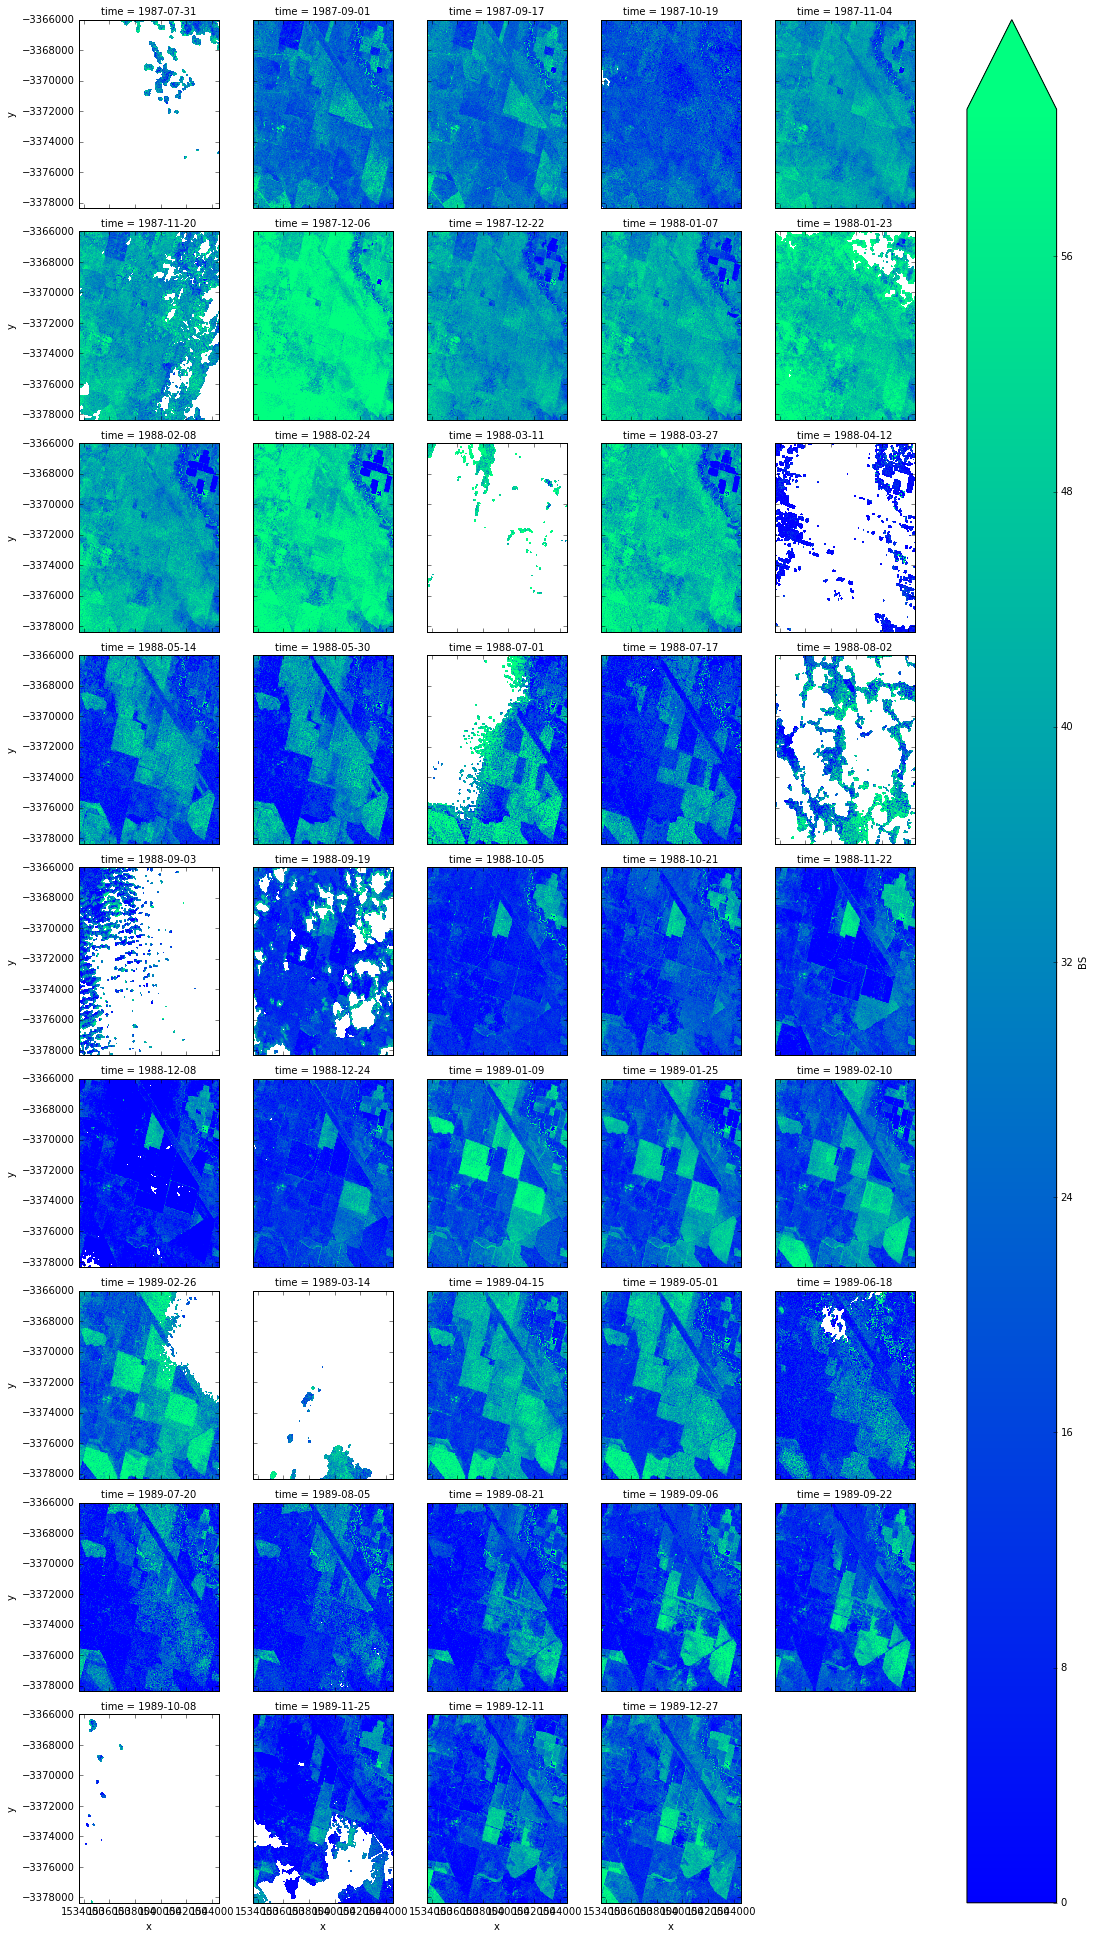

In [62]:
fc.BS.plot(col='time', col_wrap=5, robust=True, cmap=acmap)

In [63]:
# ndvi = ((data.nir - data.red) / (data.nir + data.red))

# ndvi[-10:].plot(col='time', col_wrap=5, robust=True, cmap=acmap)

In [64]:
MASK_FLAGS = {
    'contiguous': True,
    'cloud_acca': 'no_cloud',
    'cloud_fmask': 'no_cloud',
    'cloud_shadow_acca': 'no_cloud_shadow',
    'cloud_shadow_fmask': 'no_cloud_shadow',
    'blue_saturated': False,
    'green_saturated': False,
    'red_saturated': False,
    'nir_saturated': False,
    'swir1_saturated': False,
    'swir2_saturated': False
}

In [65]:
# check the MASK_FLAG  with the ga_good_pixel=True)

pq2 = dc.load(product=satsensor+'_pq_albers', like=nbar, fuse_func=ga_pq_fuser, group_by='solar_day')
mask2 = make_mask(pq2, **MASK_FLAGS)

In [66]:
mask2

<xarray.Dataset>
Dimensions:       (time: 43, x: 436, y: 494)
Coordinates:
  * y             (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
  * x             (x) float64 1.534e+06 1.534e+06 1.534e+06 1.534e+06 ...
  * time          (time) datetime64[ns] 1987-09-01 1987-09-17 1987-10-19 ...
Data variables:
    pixelquality  (time, y, x) bool True True True True True True True True ...
Attributes:
    crs: EPSG:3577

In [67]:
cloudfreeRatio=0.5
pqmask =mask2.pixelquality  
mostly_cloud_free = pqmask.sum(dim=('x', 'y')) > (cloudfreeRatio * pqmask.size / pqmask.time.size)

In [68]:
# # Apply the time-dim mask to the 3D-array (time, x, y)

# mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
# # mostly_good_ndvi.plot(col='time', col_wrap=5)

# print(mostly_good_ndvi)

# #many mostly_good_ndvi.plot(col='time', col_wrap=5,robust=True, cmap=acmap)

# startdate=str(mostly_good_ndvi.time.min().values)[:10]
# stopdate=str(mostly_good_ndvi.time.max().values)[:10]

In [69]:
# Apply the time-dim mask to the 3D-array (time, x, y)

mostly_good_fc = fc.where(mostly_cloud_free).dropna('time', how='all')
# mostly_good_ndvi.plot(col='time', col_wrap=5)

print(mostly_good_fc)

#many mostly_good_ndvi.plot(col='time', col_wrap=5,robust=True, cmap=acmap)

startdate=str(mostly_good_fc.time.min().values)[:10]
stopdate=str(mostly_good_fc.time.max().values)[:10]

<xarray.Dataset>
Dimensions:  (time: 37, x: 436, y: 494)
Coordinates:
  * y        (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
  * x        (x) float64 1.534e+06 1.534e+06 1.534e+06 1.534e+06 1.534e+06 ...
  * time     (time) datetime64[ns] 1987-09-01 1987-09-17 1987-10-19 ...
Data variables:
    BS       (time, y, x) float64 32.0 29.0 36.0 34.0 32.0 30.0 33.0 32.0 ...
    PV       (time, y, x) float64 22.0 18.0 24.0 27.0 22.0 22.0 21.0 22.0 ...
    NPV      (time, y, x) float64 45.0 52.0 39.0 38.0 45.0 47.0 44.0 45.0 ...
    UE       (time, y, x) float64 12.0 13.0 12.0 12.0 12.0 12.0 12.0 12.0 ...
Attributes:
    crs: EPSG:3577


In [70]:
print(startdate, stopdate)

('1987-09-01', '1989-12-27')


In [71]:
###  define the variable mostly_good_ndvi as BareSoil

mostly_good_ndvi= mostly_good_fc.BS

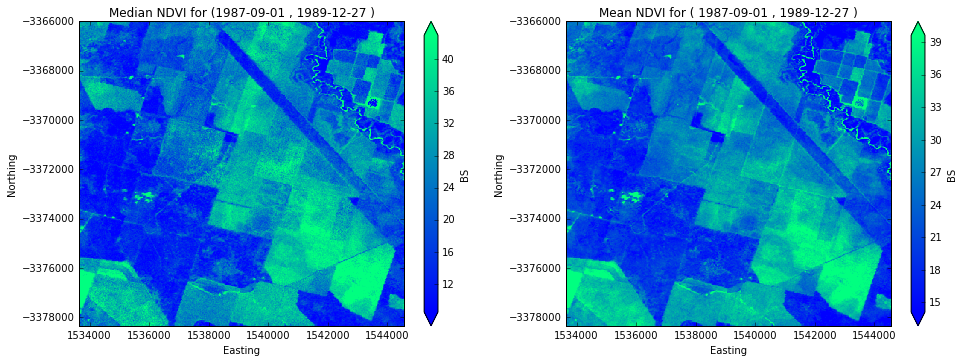

In [72]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot(robust=True, cmap=acmap)
plt.title("Median NDVI for (%s , %s )"%(startdate, stopdate)); 
plt.xlabel('Easting'); plt.ylabel('Northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot(robust=True, cmap=acmap)
# ndvi.mean(dim='time').plot()
plt.title("Mean NDVI for ( %s , %s )"%(startdate, stopdate))
plt.xlabel('Easting'); plt.ylabel('Northing')

# #------------------------------
# plt.subplot( 2,2,3 )
# mostly_good_ndwi.median(dim='time').plot()
# plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


# plt.subplot( 2,2,4 )
# mostly_good_ndwi.mean(dim='time').plot()
# # ndwi.mean(dim='time').plot()
# plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

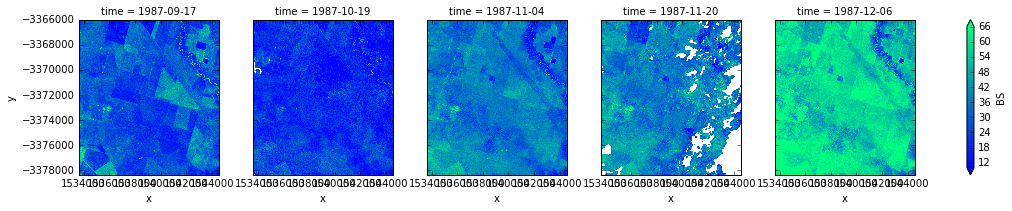

In [73]:
# try to get a subset of ndvi whose average are lower 20%. And the corresponding bands. They can then be synthentized.
# a list of times as selection criteria?
# https://www.google.com.au/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=xarray.DataArray+slicing
alist=[1,2,3,4,5]
subset_ndvi=mostly_good_ndvi.isel(time=alist)

subset_ndvi.plot(col='time', col_wrap=5,robust=True, cmap=acmap)


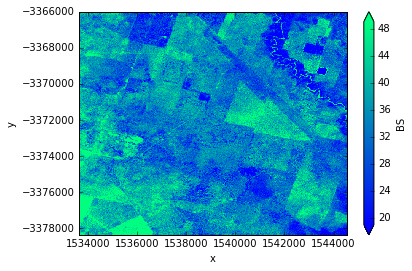

In [74]:
subset_ndvi.median(dim='time').plot(robust=True, cmap=acmap)

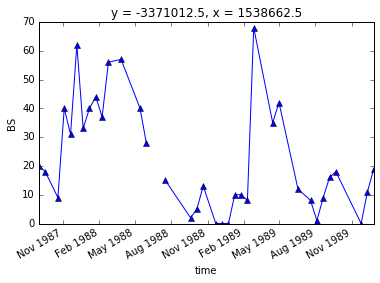

In [75]:
mostly_good_ndvi.isel(x=[200], y=[200]).plot(marker='^')

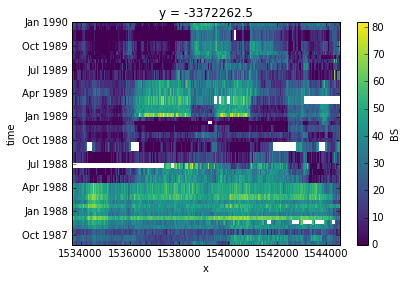

In [76]:

mostly_good_ndvi.isel(y=250).plot()

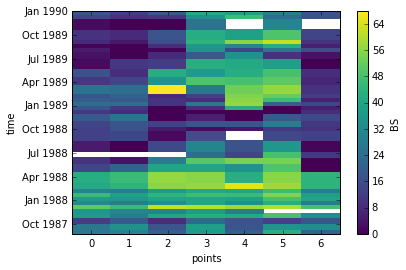

In [77]:
#A line shapefile with pairs of coordinates (using sel_points instead of isel_points) 
# would be able to be interpolated into something less blocky for the next plot.

mostly_good_ndvi.isel_points(x=[0, 100, 200, 300, 300, 400,420], 
                             y=[200, 200, 200, 250, 300, 400,420]).plot(x='points', y='time')

In [78]:
mostly_cloud_free

<xarray.DataArray 'pixelquality' (time: 43)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1987-09-01 1987-09-17 1987-10-19 ...

In [79]:
ndvi_mean = mostly_good_ndvi.mean(dim=['x', 'y'])  # average over the image pixels

pdser = ndvi_mean.to_pandas()  # pd.Series

df = pdser.to_frame(name='NDVI')  # convert to dataframe

        # df['PROD_TYPE'] = self.prod_type  # add a new column

df.sort_index()


NDVI
time                 
1987-09-01  26.692192
1987-09-17  28.544910
1987-10-19  19.943612
1987-11-04  36.186151
1987-11-20  38.134153
1987-12-06  55.563357
1987-12-22  35.331227
1988-01-07  39.319081
1988-01-23  48.851516
1988-02-08  37.723754
1988-02-24  50.060483
1988-03-27  44.700284
1988-05-14  23.652291
1988-05-30  21.569991
1988-07-01  31.224118
1988-07-17  15.902700
1988-09-19  15.221037
1988-10-05  11.740022
1988-10-21  16.728940
1988-11-22  14.778549
1988-12-08   6.518251
1988-12-24  14.631866
1989-01-09  27.419279
1989-01-25  23.310947
1989-02-10  25.567446
1989-02-26  33.223622
1989-04-15  30.295839
1989-05-01  27.279138
1989-06-18  15.873404
1989-07-20  15.003556
1989-08-05  14.260986
1989-08-21  15.180951
1989-09-06  18.172120
1989-09-22  18.140270
1989-11-25  11.240487
1989-12-11  17.985440
1989-12-27  24.101623

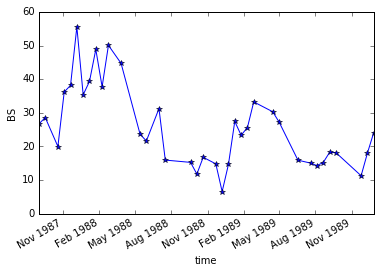

In [80]:
ndvi_mean.plot(marker='*')

# Further Filtering of images

In [81]:
# ndvi_mean.plot()
small20_ndvi=pdser.quantile(0.9)

print("NDVI threshold: ", small20_ndvi)

('NDVI threshold: ', 41.471562418749755)


In [82]:
ndvi_mean_mask= (ndvi_mean >= small20_ndvi)

In [83]:
ndvi_mean_mask

<xarray.DataArray 'BS' (time: 37)>
array([False, False, False, False, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1987-09-01 1987-09-17 1987-10-19 ...

In [84]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi2 = mostly_good_ndvi.where(ndvi_mean_mask).dropna('time', how='all')

print(mostly_good_ndvi2)

<xarray.DataArray 'BS' (time: 4, y: 494, x: 436)>
array([[[ 56.,  61.,  60., ...,  51.,  44.,  54.],
        [ 56.,  59.,  56., ...,  55.,  48.,  46.],
        [ 58.,  61.,  59., ...,  47.,  51.,  49.],
        ..., 
        [ 61.,  62.,  64., ...,  28.,  34.,  30.],
        [ 67.,  63.,  66., ...,  29.,  26.,  28.],
        [ 67.,  62.,  60., ...,  29.,  33.,  27.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ 64.,  59.,  58., ...,  31.,  34.,  22.],
        [ 65.,  59.,  60., ...,  33.,  30.,  32.],
        [ 61.,  58.,  55., ...,  29.,  33.,  28.]],

       [[ 57.,  58.,  59., ...,  48.,  54.,  40.],
        [ 55.,  57.,  62., ...,  52.,  43.,  49.],
        [ 52.,  55.,  54., ...,  46.,  50.,  49.],
        ..., 
        [ 53.,  51.,  56., ...,  31.,  16.,  24.],
        [ 61.,  59.,  57., ...,  25.,  15.,  30.],
        [ 67.,  56.,  55., ...,  20.,

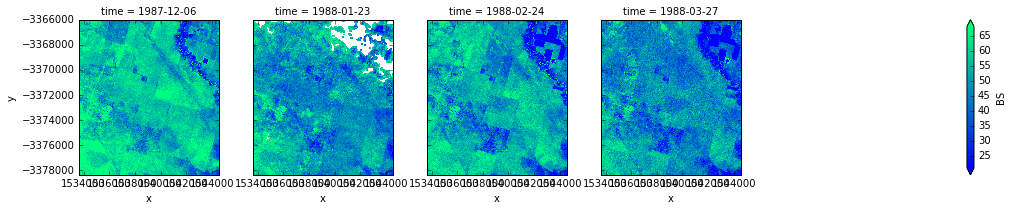

In [85]:
mostly_good_ndvi2.plot(col='time', col_wrap=5, robust=True, cmap=acmap)

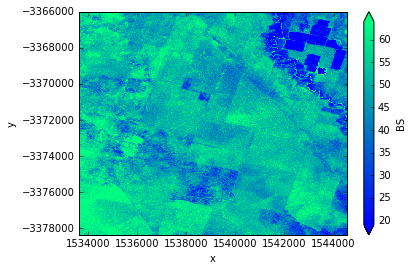

In [86]:

mostly_good_ndvi2.median(dim='time').plot(robust=True, cmap=acmap)

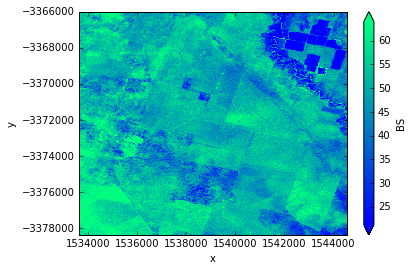

In [87]:
# cmap: http://matplotlib.org/examples/color/colormaps_reference.html

mostly_good_ndvi2.mean(dim='time').plot(robust=True, cmap=acmap)

In [88]:
nbar1 =nbar.where(mostly_cloud_free).dropna('time', how='all')

In [89]:
nbar2=nbar1.where(ndvi_mean_mask).dropna('time', how='all')

In [90]:
mostly_good_ndvi2_mask=(mostly_good_ndvi2 >= small20_ndvi)

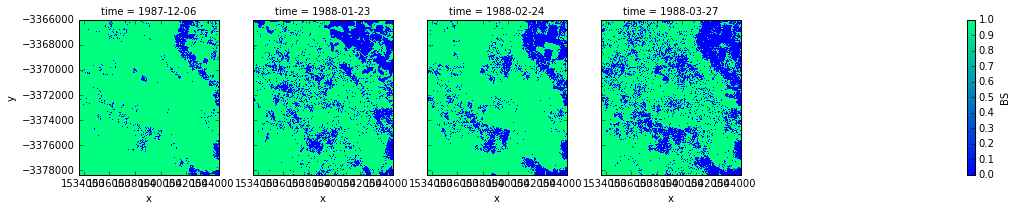

In [91]:
mostly_good_ndvi2_mask.plot(col='time', col_wrap=5, robust=True, cmap=acmap)

In [92]:
nbar2_maskoff_high_ndvi = nbar2.where(mostly_good_ndvi2_mask)

In [93]:
synnbar2=nbar2_maskoff_high_ndvi.mean(dim='time', keep_attrs=True )

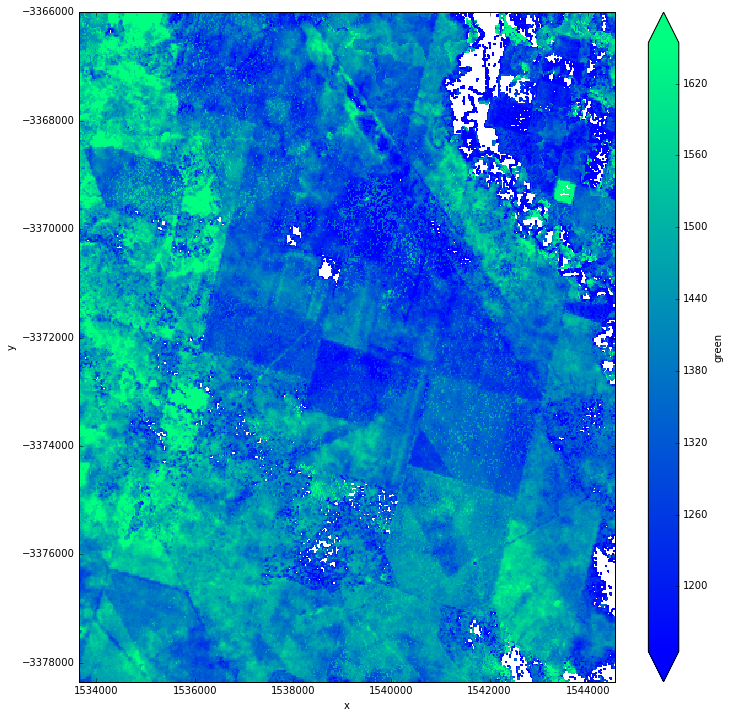

In [94]:
plt.figure(figsize=(12,12))
synnbar2.green.plot(robust=True, cmap=acmap)
# syndata2 is the  mean() of serveral low NDVI observations images with highndvi masked-off.

# syndata2 is the  mean() of serveral low NDVI observations images whose high-ndvi pixels have been masked-off

In [95]:
synndvi=(synnbar2.nir- synnbar2.red)/(synnbar2.nir +synnbar2.red)

('NDVI Low 20%', 41.471562418749755)


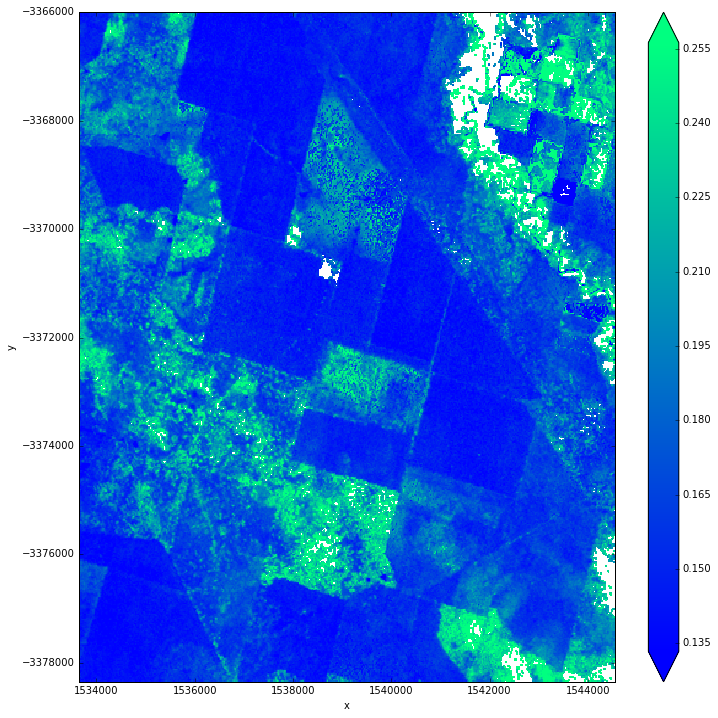

In [96]:
print("NDVI Low 20%",  small20_ndvi)
plt.figure(figsize=(12,12))
synndvi.plot(robust=True, cmap=acmap)

In [97]:
# here is a set of lowest average NDVI images.
nbar2

<xarray.Dataset>
Dimensions:  (time: 4, x: 436, y: 494)
Coordinates:
  * y        (y) float64 -3.366e+06 -3.366e+06 -3.366e+06 -3.366e+06 ...
  * x        (x) float64 1.534e+06 1.534e+06 1.534e+06 1.534e+06 1.534e+06 ...
  * time     (time) datetime64[ns] 1987-12-06 1988-01-23 1988-02-24 1988-03-27
Data variables:
    blue     (time, y, x) float64 1.069e+03 1.04e+03 1.04e+03 1.04e+03 ...
    green    (time, y, x) float64 1.541e+03 1.511e+03 1.511e+03 1.541e+03 ...
    red      (time, y, x) float64 1.924e+03 1.898e+03 1.898e+03 1.898e+03 ...
    nir      (time, y, x) float64 2.583e+03 2.517e+03 2.55e+03 2.517e+03 ...
    swir1    (time, y, x) float64 3.306e+03 3.239e+03 3.239e+03 3.261e+03 ...
    swir2    (time, y, x) float64 2.835e+03 2.867e+03 2.835e+03 2.835e+03 ...
Attributes:
    crs: EPSG:3577

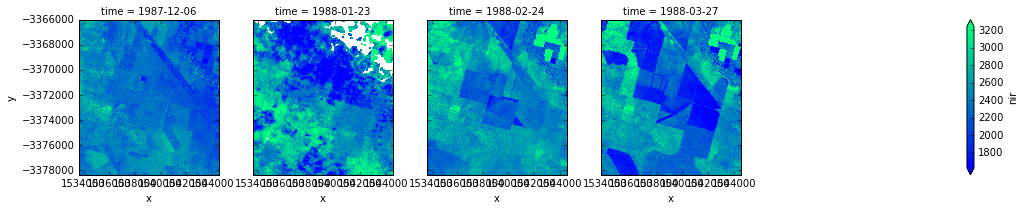

In [98]:
nbar2.nir.plot(col='time', col_wrap=5,robust=True, cmap=acmap)

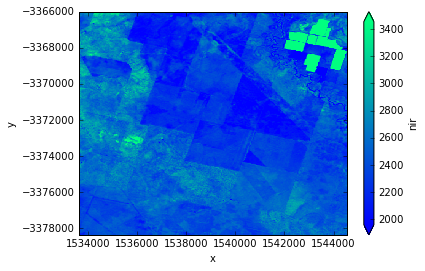

In [99]:
nbar2.nir.median(dim='time').plot(robust=True, cmap=acmap)

In [100]:
import rasterio

DEFAULT_PROFILE = {
    'blockxsize': 256,
    'blockysize': 256,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': -999,  #0.0,
    'photometric': 'RGA',    #'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff filename

    :attr bands: ordered list of dataset names
    :attr time_index: the time index of data slice to be output to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop()),
        'nodata': -999 #dataset.red.nodata
    })
    profile.update(profile_override)
    
    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            if time_index is None:
                #print(data.data)  # pure 2D numeric matrix
                dest.write(data.data, bandnum)
            else:
                dest.write(data.isel(time=time_index).data, bandnum)



In [101]:
# export dataset of xarray.Dataset
import os

def export_datasets(ds, fn_prefix):
    """
    loop over every datasets in ds, output geotiff and rgb image
    see the filtered version below
    """
    for itime in xrange (0,len(ds.time)):
        #fntime=str(ds.time.values[itime])[:19].replace(':','')
        fntime=str(ds.time.values[itime])[:10].replace(':','')
        #fntime='yyyy-mm-dd'
        fname ="%s_%s.tiff"%(fn_prefix,fntime)
        fname2="%s_%s.png"%(fn_prefix,fntime)
        
        path2fname=os.path.join("/short/v10/fxz547/LowNDVI",fname)
        path2fname2 =os.path.join("/short/v10/fxz547/LowNDVI",fname2)

        write_geotiff(path2fname,ds, itime)
        
        #make_rgb_images(ds, itime, path2fname2 )
        
        

In [102]:

fnpref = '%s_%s_nbar' % (AOI_NAME, satsensor)

export_datasets(data2, fnpref)

NameError: name 'data2' is not defined

In [ ]:
# This is the new subset of lower-NDVI images
data2


In [ ]:
# bands synthetic image constructed from a set data2

#OK syn_band= data2.median(dim='time', keep_attrs=True )

syn_band= data2.mean(dim='time', keep_attrs=True )

# min() func does not make sense here:  syn_band= data2.min(dim='time', keep_attrs=True )

In [ ]:
syn_band

In [ ]:
syn_band.data_vars.keys() #.values()


In [ ]:
syn_band.blue.data

In [ ]:
syn_band.data_vars.values()[1].data  # blue  index=1, coastal_aerosol=0

In [ ]:
filename=os.path.join("/short/v10/fxz547/LowNDVI", '%s_%s_nbar_synband.tiff'%(AOI_NAME, satsensor))

write_geotiff(filename, syn_band ) #, time_index=None, profile_override=None)


In [ ]:
syn_ndvi= (syn_band.nir - syn_band.red )/  (syn_band.nir + syn_band.red )

In [ ]:
plt.figure(figsize=(12,12))
# mask (syn_ndvi >0.3).plot(robust=True) # cmap=acmap)

syn_ndvi.plot(robust=True) # cmap=acmap)

In [ ]:
# set a datetime, try to make a dim as virtual datetime
# syn_band.attrs['time']='2014-00-00'
# export_datasets(syn_band, fnpref)

In [ ]:

filename=os.path.join("/short/v10/fxz547/LowNDVI",'%s_%s_nbar_syndata_refined.tiff'%(AOI_NAME, satsensor))

write_geotiff(filename, syndata2 ) #, time_index=None, profile_override=None)


In [ ]:
# this function is Not working


# def make_rgb(data):
#     """ data must have three measurements R G B
#     https://github.com/data-cube/agdc-v2/blob/develop/examples/notebooks/Datacube_Summary.ipynb
#     https://localhost:5999/notebooks/geodanalytics/localz/agdcv2_display_RGB_images.ipynb#Select-a-stack-of-images,-mask-off-invalid-pixels,-make-RGB-natural-color-images
#     https://localhost:5999/notebooks/geodanalytics/BareSoil/export_near_cloudfree_landsat_imagery_stack.ipynb
#     """
#     fake_saturation = 3500 #4000
#     rgb = data.to_array(dim='color')
#     rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
#     rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
#     rgb /= fake_saturation  # scale to [0, 1] range for imshow

#     # rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
#     #                 col='time', col_wrap=5, add_colorbar=False)
#     rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
#                     col='time', col_wrap=5, add_colorbar=False)
    
#     return rgb

In [ ]:

def scale_array2(arr, fake_saturation=3500):
    """
    Linearly scales array 'arr' clippoff fake_saturation value. 
    If the surf reflectance value is too large, it will be set as fake_saturation.
    What happen to the -999 values?
    
    return scaled  2D array image with value in (0,255)
    """
    
    clipped_arr= arr.where(arr<fake_saturation).fillna(fake_saturation)
   
    return (255*clipped_arr)/fake_saturation


def make_rgb_image(bands,outfname=None, fake_saturation = 3500):
    """
    Create a RGB image using bands.{red,green,blue}
    """
    print ("Start making RGB image  ")
        
    plt.figure( figsize=(10,10) )
    
    red_img=bands.red
    green_img=bands.green
    blue_img = bands.blue
    
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print("Red image shape and y,x size", red_img.shape,y_size,x_size)

    
    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    
    #rgb_image = np.zeros((y_size, x_size, 3), dtype='int16') #not work int16	-32,768 to 32,767

 
#     fake_saturation = 3500
    rgb_image[:,:,0] = scale_array2(red_img,fake_saturation)
    rgb_image[:,:,1] = scale_array2(green_img,fake_saturation)
    rgb_image[:,:,2] = scale_array2(blue_img,fake_saturation)
    
    strDate="yyy-mm-dd"   #str(nbar.time.values[itime])[:10]
    title_str= 'Landsat Image %s'%(strDate)
    plt.title(title_str)
    plt.ylabel('Northing'); plt.xlabel('Easting');
    
    if outfname is None:
        plt.imshow(rgb_image)
        output_figure_name = 'nbar_nature_color.png'
        plt.savefig(output_figure_name, dpi=400)
    else:
        plt.imsave(outfname, rgb_image)  #only the image would NOT save the title and axis label
        plt.close()
    


In [ ]:
rgb= make_rgb_image(syndata2)
# syndata2 is the  mean() of serveral low NDVI observations images whose high-ndvi pixels have been masked-off

In [ ]:
# syn_band was defined above as mean() of 20% low NDVI images
rgb= make_rgb_image(syn_band,fake_saturation = 3000)

In [ ]:
print small20_ndvi